# EEE4114F ML Project Code Part 1: Loading and Understanding the Data

The first step in building our human activity recognition (HAR) classifier was to determine which subset of the available data to use. The dataset comprises multiple files and sensor modalities, but it is neither efficient nor always beneficial to use all of them. Therefore, we evaluated which sensor signals were likely to contribute most meaningfully to classification accuracy, while balancing computational cost and potential overfitting.

The dataset is divided into three main folders:

- **(A) DeviceMotion_data:** Contains a rich combination of accelerometer, gyroscope, and orientation-related features — 12 features in total.

- **(B) Accelerometer_data:** Includes only the raw accelerometer readings (x, y, z) — 3 features.

- **(C) Gyroscope_data:** Includes only the raw gyroscope readings (x, y, z) — 3 features.


From these, **(A) DeviceMotion_data** provides the most comprehensive set of features, combining both linear and rotational data, as well as derived orientation estimates:

- **Attitude (roll, pitch, yaw)** showing device orientation (e.g., facing up/down)
- **Gravity (x, y, z)** showing static acceleration (orientation wrt gravity)
- **Rotation Rate (x, y, z)** showing angular velocity from gyroscope
- **User Acceleration (x, y, z)** showing motion (dynamic body acceleration)

In this document we try to understand the data a bit better and use our human brains to make decisions on how we're going to proceed in the training section (part 2).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Useful functions
Here are some useful functions from motionsense.ipyb we have copied. We didn't copy get_ds_infos() since we don't really care about subject information. We edited the code to have just classified subjects [1-24] without needing to read the subject info.

In [34]:
def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset. 

    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        A list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list



def create_time_series(dt_list, act_labels, trial_codes, subject_ids=None, mode="mag", labeled=True):
    """
    Defines what data to include for a given set, using selected sensors and subjects.

    Args:
        dt_list: List of sensor columns to include.
        act_labels: List of activity labels (e.g. ["dws", "ups", "wlk"...]).
        trial_codes: Dictionary mapping activity to trial numbers.
        subject_ids: List of subject IDs to include. Example: [1, 2, ..., 24]
        mode: "raw" = keep all sensor components; "mag" = magnitude only.
        labeled: True to include activity labels.

    Returns:
        A pandas DataFrame containing time-series sensor data.
    """
    if subject_ids is None:
        subject_ids = list(range(1, 25))  # Default: use all subjects

    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list * 3)
    dataset = np.zeros((0, num_data_cols + 1)) if labeled else np.zeros((0, num_data_cols))

    print("[INFO] -- Creating Time-Series")
    for sub_id in subject_ids:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act]:
                # For Olive: fname = f'/Users/olivekschonfeldt/Library/CloudStorage/OneDrive-UniversityofCapeTown/EEE4114F DSP/ML Project 2025/motion-sense-master/data/A_DeviceMotion_data/{act}_{trial}/sub_{sub_id}.csv'
                fname = f'/Users/olivekschonfeldt/Library/CloudStorage/OneDrive-UniversityofCapeTown/EEE4114F DSP/ML Project 2025/motion-sense-master/data/A_DeviceMotion_data/{act}_{trial}/sub_{sub_id}.csv'
                try:
                    raw_data = pd.read_csv(fname)
                    raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                    vals = np.zeros((len(raw_data), num_data_cols))
                    for x_id, axes in enumerate(dt_list):
                        if mode == "mag":
                            vals[:, x_id] = (raw_data[axes] ** 2).sum(axis=1) ** 0.5
                        else:
                            vals[:, x_id * 3:(x_id + 1) * 3] = raw_data[axes].values
                        vals = vals[:, :num_data_cols]
                    if labeled:
                        lbls = np.array([[act_id]] * len(raw_data))
                        vals = np.concatenate((vals, lbls), axis=1)
                    dataset = np.append(dataset, vals, axis=0)
                except FileNotFoundError:
                    print(f"[WARNING] File not found: {fname}. Skipping.")
                    continue

    cols = []
    for axes in dt_list:
        cols += axes if mode == "raw" else [str(axes[0][:-2])]

    if labeled:
        cols += ["act"]

    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset



ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

### Loading the data
Here we extract the data to obtain our new **dataset**. We are only going to extract all features (attitude(roll, pitch, yaw), gravity(x,y,z), rotationRate(x,y,z) and userAcceleration(x,y,z)) for all activity types.

In [4]:
# Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"

sdt = ["attitude", "gravity", "rotationRate", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS  # includes all six activities
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = {act: TRIAL_CODES[act] for act in act_labels}
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'gravity', 'rotationRate', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0


## Choosing Which Data Types to Include by a Visualisation Study

### Visualisation of Attitude Data per Activity
Here we plot the first 5000 samples per activity for the attitude data.

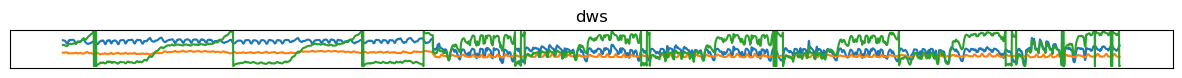

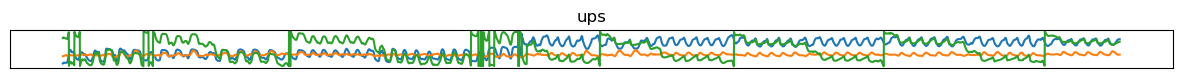

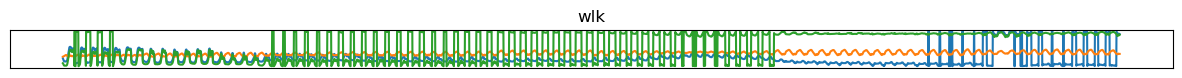

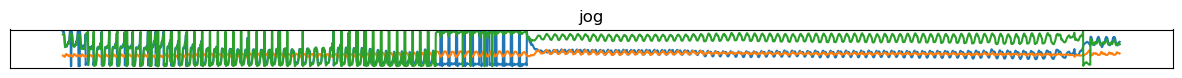

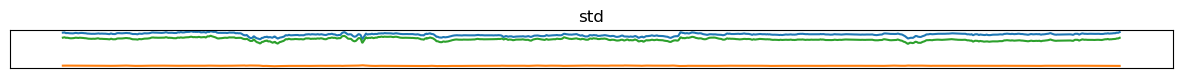

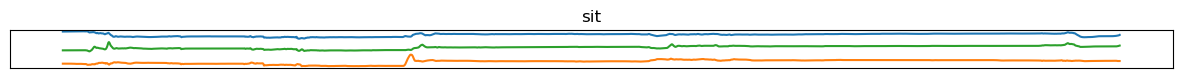

In [30]:
# Define sensor axes to plot
sensor_axes = ['attitude.roll', 'attitude.pitch', 'attitude.yaw']

for i, act_name in enumerate(act_labels):
    subset = dataset[dataset['act'] == i].head(5000)
    plt.figure(figsize=(15, 0.5))
    plt.title(act_name)
    for axis in sensor_axes:
        plt.plot(subset.index, subset[axis], label=axis)
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    plt.show()

### Visualisation of Gravity Data per Activity
Here we plot the first 5000 samples per activity for the gravity data.

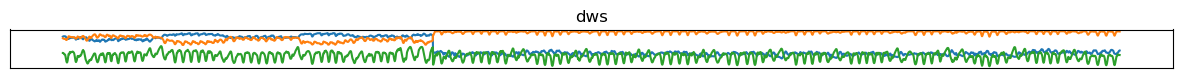

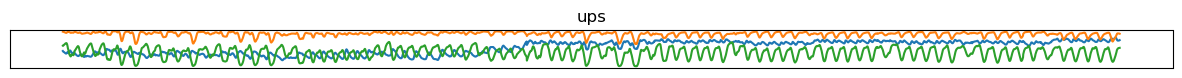

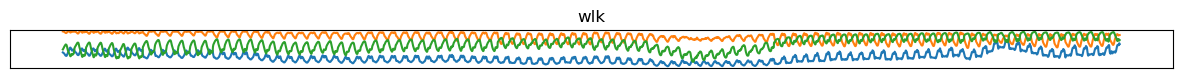

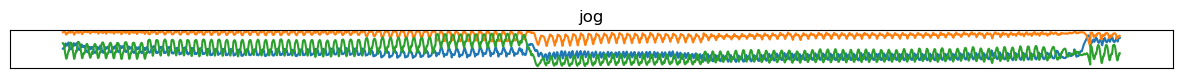

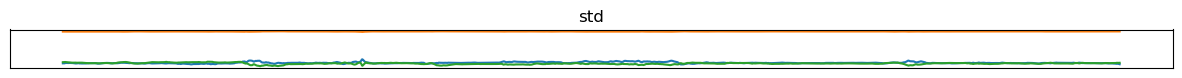

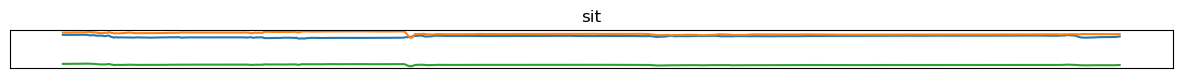

In [31]:
# Define sensor axes to plot
sensor_axes = ['gravity.x', 'gravity.y', 'gravity.z']

for i, act_name in enumerate(act_labels):
    subset = dataset[dataset['act'] == i].head(5000)
    plt.figure(figsize=(15, 0.5))
    plt.title(act_name)
    for axis in sensor_axes:
        plt.plot(subset.index, subset[axis], label=axis)
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    plt.show()
    

### Visualisation of Rotation Rate Data per Activity
Here we plot the first 5000 samples per activity for the rotation rate data.

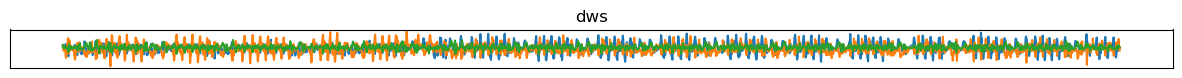

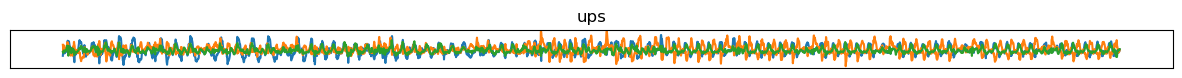

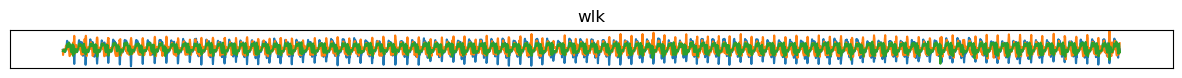

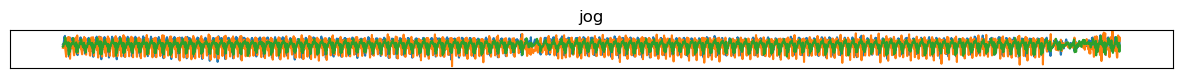

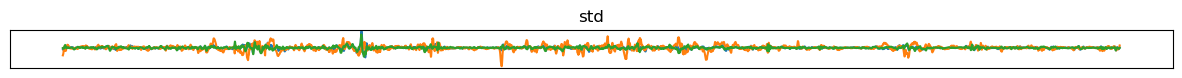

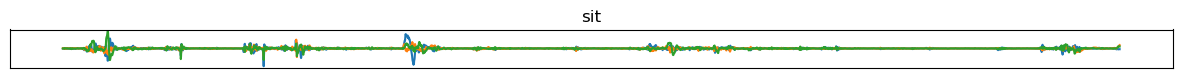

In [32]:
# Define sensor axes to plot
sensor_axes = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']

for i, act_name in enumerate(act_labels):
    subset = dataset[dataset['act'] == i].head(5000)
    plt.figure(figsize=(15, 0.5))
    plt.title(act_name)
    for axis in sensor_axes:
        plt.plot(subset.index, subset[axis], label=axis)
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    plt.show()

### Visualisation of Acceleration Data per Activity
Here we plot the first 5000 samples per activity for the user acceleration data.

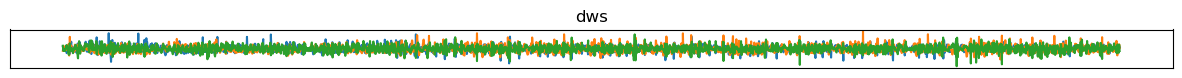

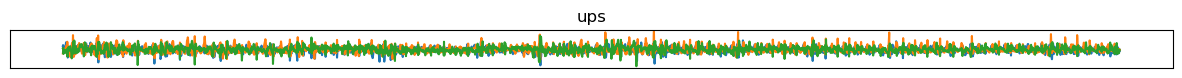

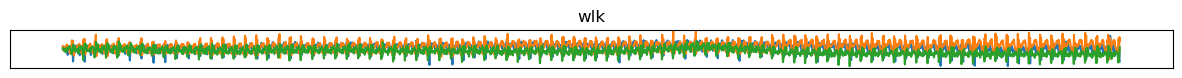

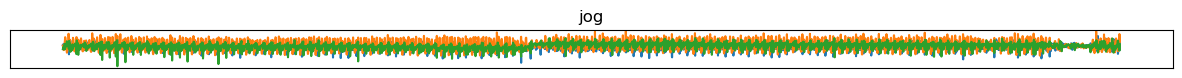

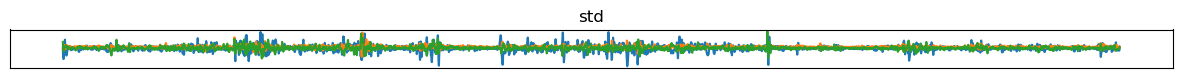

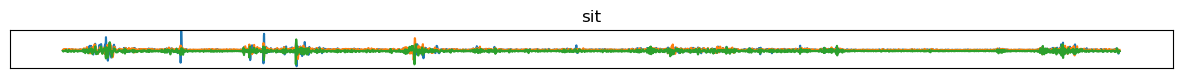

In [33]:
# Define sensor axes to plot
sensor_axes = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

for i, act_name in enumerate(act_labels):
    subset = dataset[dataset['act'] == i].head(5000)
    plt.figure(figsize=(15, 0.5))
    plt.title(act_name)
    for axis in sensor_axes:
        plt.plot(subset.index, subset[axis], label=axis)
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    plt.show()

It was beneficial to plot this data because it helps us distinguish features such as:
- Dynamic activities like walking stairs, walking and jogging have large peaks and dips, while the more conservative activities like standing and sitting have a flatter range of values.
- Walking and jogging have a 'cadence' to them.

However we have a few concerns:
- There seems to be some 'noise' present in sitting (and what else???)
- Walking downstairs and upstairs looks pretty similar even though they're two different directions of motion.

### Choosing Data Types Remarks

From the visualisation studies, we have noted that **Rotation Rate** and **User Acceleration** are quite noisy—especially for more static activities like standing and sitting, where the signals are surprisingly bumpy and inconsistent. This noise makes it harder to distinguish between subtle differences in movement.

Meanwhile, **Attention** and **Gravity** signals appear much cleaner and more structured. They show smoother transitions and clearer patterns that align well with different activities.

Gravity seems to carry valuable information about the cadence of the user, especially useful for distinguishing between the rhythm of moving vs flat line of not moving. It also can distinguish between sitting and standing depending on whether x, y or z is greater - information which **Rotation Rate** and **User Acceleration** does not contain.

Attitude must also be included as it has some clear indication of the upstairs vs downstairs based on an increasing or decreasing trend in yaw (green) over large time windows. It also has similar information of rhythmic vs flatline plots.

## Understanding Sample Size
Here we gain an understanding of the sample size of each activity so that we can assess the balance of the dataset. This helps identify if any classes are underrepresented, which may affect model training and performance.


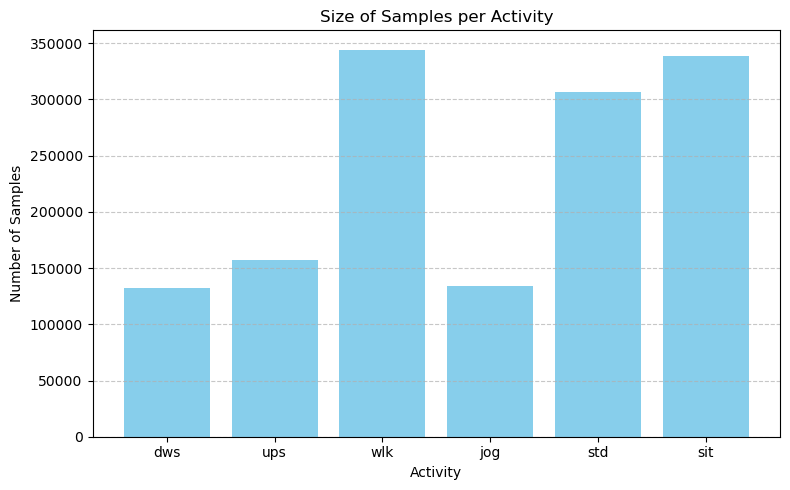

In [5]:
# Count the number of samples per activity label
activity_counts = dataset["act"].value_counts().sort_index()

# Convert numeric labels back to activity names
activity_names = act_labels  # this must match the order of label IDs: 0, 1, 2, ...
activity_labels = [activity_names[int(i)] for i in activity_counts.index]

# Plot
plt.figure(figsize=(8,5))
plt.bar(activity_labels, activity_counts.values, color='skyblue')
plt.xlabel("Activity")
plt.ylabel("Number of Samples")
plt.title("Size of Samples per Activity")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Sample Size Remarks
This shows us it will be harder for the model to accurately recognise less-represented classes like downstairs, upstairs, and jogging.

# Understanding Recording Lengths

In [37]:
# Dictionary to store lengths of individual recordings
recording_lengths = []

# Iterate through subjects, activities, and trials
for sub_id in range(1, 25):  # subjects 1 to 24
    for act_id, act in enumerate(act_labels):
        for trial in TRIAL_CODES[act]:
            # for Olive: fname = f'/Users/olivekschonfeldt/Library/CloudStorage/OneDrive-UniversityofCapeTown/EEE4114F DSP/ML Project 2025/motion-sense-master/data/A_DeviceMotion_data/{act}_{trial}/sub_{sub_id}.csv'
            fname = f'/Users/olivekschonfeldt/Library/CloudStorage/OneDrive-UniversityofCapeTown/EEE4114F DSP/ML Project 2025/motion-sense-master/data/A_DeviceMotion_data/{act}_{trial}/sub_{sub_id}.csv'
            try:
                raw_data = pd.read_csv(fname)
                recording_lengths.append(len(raw_data))  # number of rows = length of recording
            except FileNotFoundError:
                continue

# Calculate statistics
min_len = np.min(recording_lengths)
max_len = np.max(recording_lengths)
mean_len = np.mean(recording_lengths)

print("\n=== Recording Length Stats ===")
print(f"Minimum length: {min_len} samples")
print(f"Maximum length: {max_len} samples")
print(f"Average length: {mean_len:.2f} samples")


=== Recording Length Stats ===
Minimum length: 377 samples
Maximum length: 16424 samples
Average length: 3924.62 samples


### Recording Lengths Remarks
The minimum recording length is 377 samples, while the maximum is 16 424 and the mean length is around 3 925. Knowing this helps us inform ourselves going into ML training that there is significant variability in recording durations across trials and subjects. It also informs us of what a suitable window size could be.

Padding or truncation strategies may be required to standardize input lengths for models that expect fixed-size inputs.